# RAG Evaluation




Author: [Vladimir Ageev](www.linkedin.com/in/vladimir-ageev-ds)  
DS / MLE with experience in recommendation systems and NLP  
Currently involved in a project on building a RAG

### Installing dependencies

In [ ]:
! pip install chromadb sentence-transformers langchain datasets
! pip install langchain-community langchain-chroma
! pip install langchain-openai ragas
! pip install gdown

### Download required data

In [ ]:
# download

# frames
! gdown https://drive.google.com/uc?id=13tZJnRcgde8kdhhWWkoYTt7WtgFttT0x
# chroma index
! gdown https://drive.google.com/uc?id=1mnb0rgmciMZax21ZmoYGRlx3e7VIcNhV
# unzip

! unzip ./chroma_30K.zip -d ./
! unzip ./frames_benchmark_sampled_150.zip -d ./

## Dataset

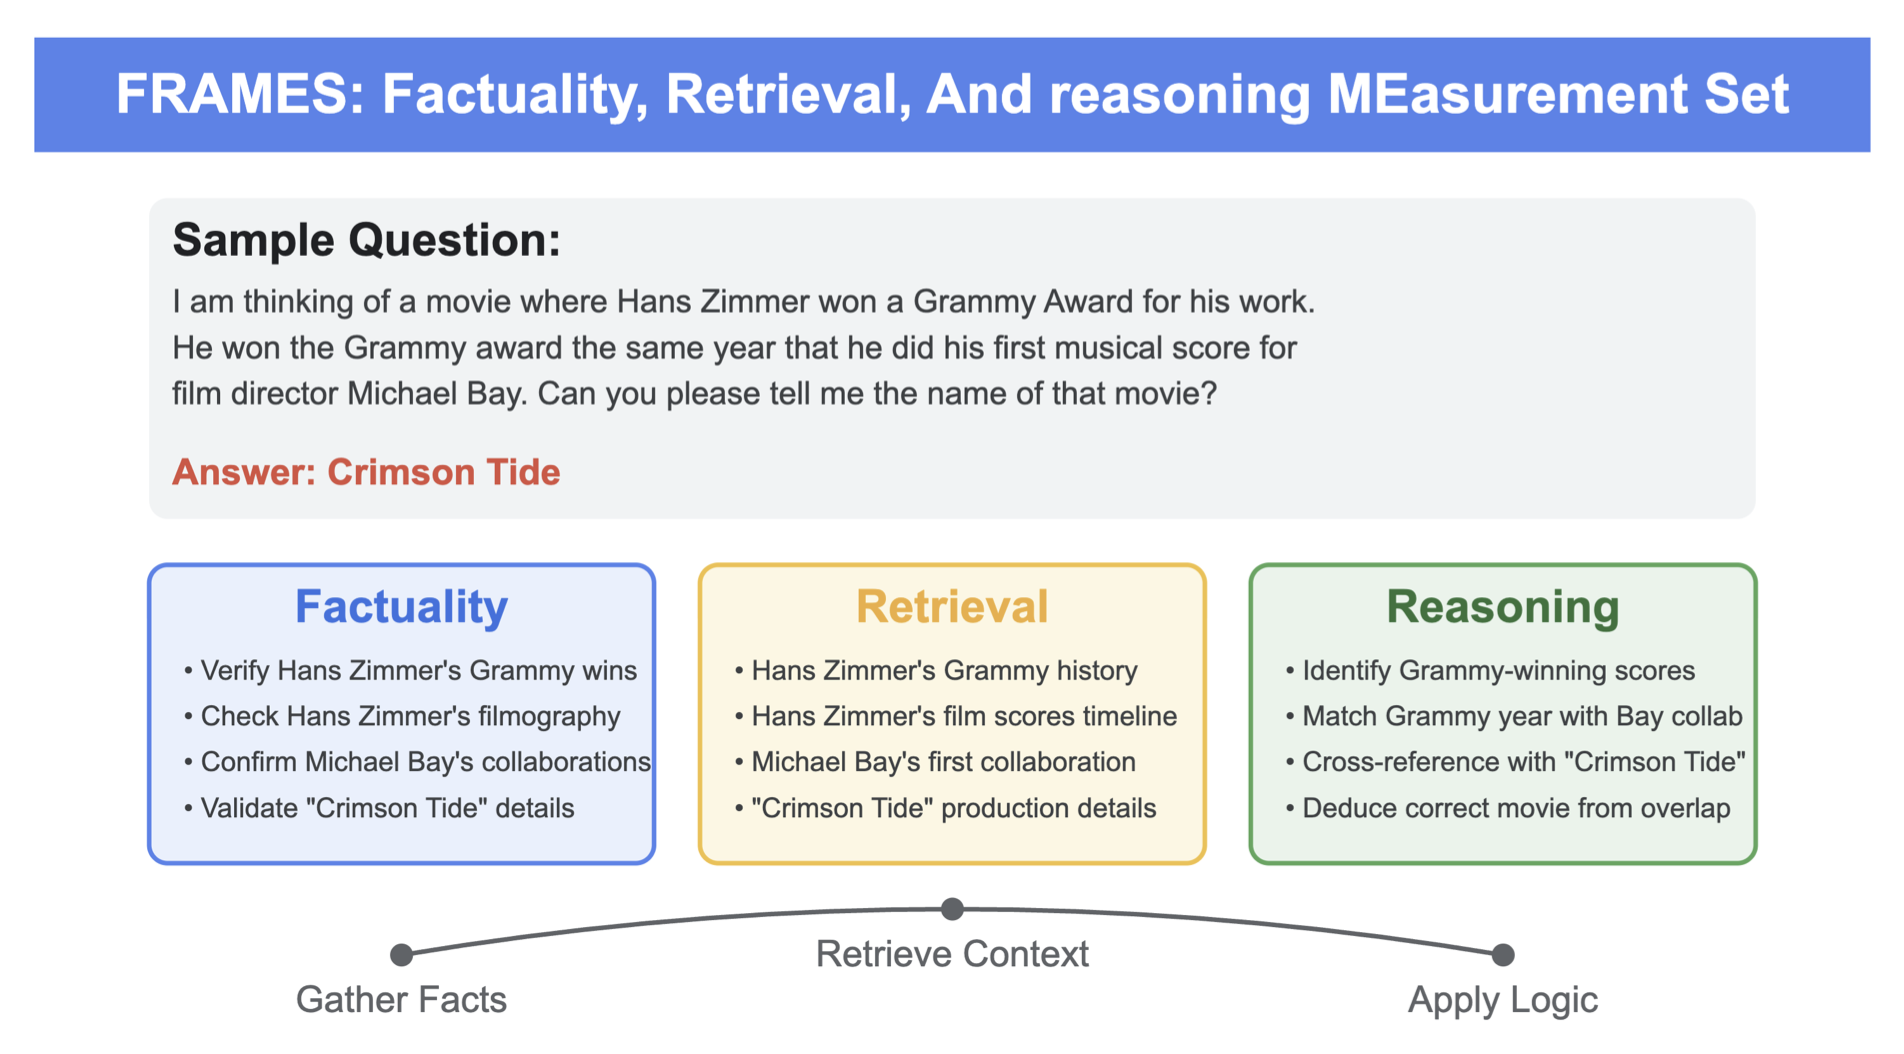

In [ ]:
from datasets import load_from_disk

frames_ds = load_from_disk("frames_benchmark_sampled_150")

In [ ]:
from pprint import pprint

pprint(frames_ds[0])

{'Answer': 'Graham High School in St. Paris Ohio',
 'Prompt': 'What is the name of the high school and hometown of the Olympic '
           'Gold Medalist winner who won 4-3 against Hassan Yazdani at the '
           'Japan Olympics in 2020?',
 'Unnamed: 0': 546,
 'reasoning_types': 'Multiple constraints',
 'wiki_links': '{"https://en.wikipedia.org/wiki/2020_Summer_Olympics": {"id": '
               '"1610886", "url": '
               '"https://en.wikipedia.org/wiki/2020_Summer_Olympics", "title": '
               '"2020 Summer Olympics", "text": "The  officially the  and also '
               'known as  was an international multi-sport event held from '
               '23\\u00a0July to 8\\u00a0August 2021 in Tokyo, Japan, with '
               'some preliminary events that began on 21 July 2021. Tokyo was '
               'selected as the host city during the 125th IOC Session in '
               'Buenos Aires, Argentina, on 7 September 2013.\\n\\nOriginally '
               'schedule

## Ingestion & Retrieval

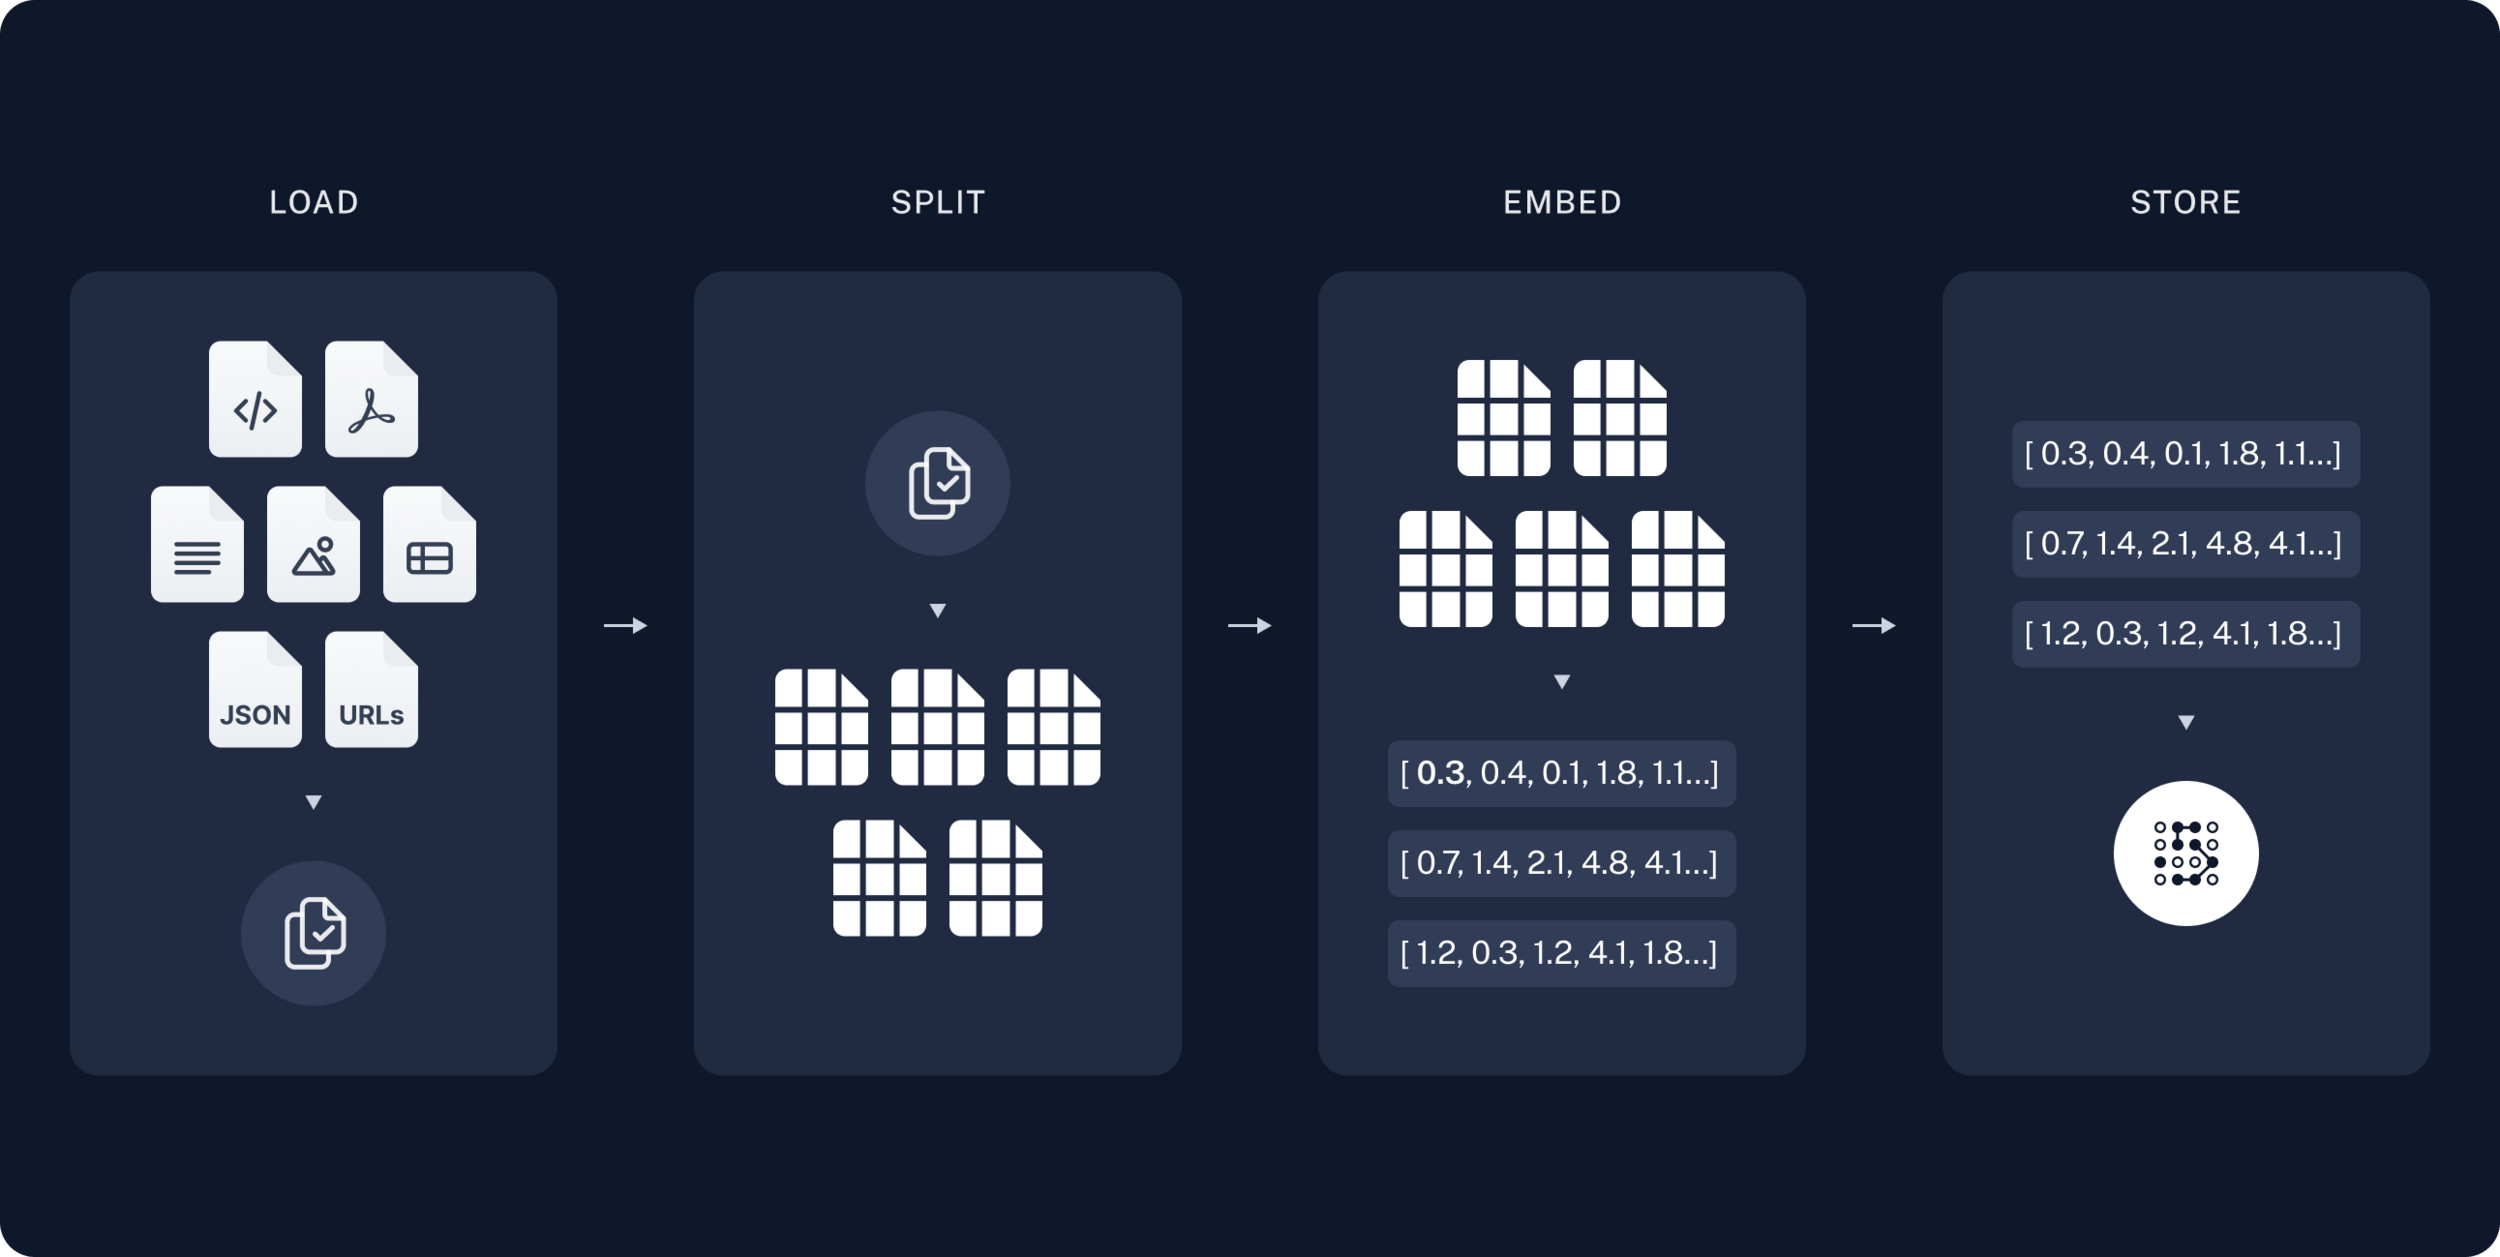

In [ ]:
### Initialize vector storage
from sentence_transformers import SentenceTransformer
from langchain_chroma import Chroma
from langchain_core.embeddings.embeddings import Embeddings


class AcrticEmbeddings(Embeddings):
    def __init__(self, model_name, batch_size=32):
        self.model = SentenceTransformer(
            model_name,
            trust_remote_code=True,
            device="cuda",
            model_kwargs={"torch_dtype": "float16"},
        )
        self.batch_size = batch_size

    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        """Embed search docs.

        Args:
            texts: List of text to embed.

        Returns:
            List of embeddings.
        """
        return self.model.encode(texts, batch_size=self.batch_size)

    def embed_query(self, text: str) -> list[float]:
        """Embed query text.

        Args:
            text: Text to embed.

        Returns:
            Embedding.
        """
        return self.model.encode(text, batch_size=self.batch_size, prompt="query")


model_name = "Snowflake/snowflake-arctic-embed-m-v1.5"

chroma_client = Chroma(
    collection_name="wiki_chunks_30K",
    persist_directory="./chroma_30K",
    embedding_function=AcrticEmbeddings(model_name),
)

print(chroma_client._collection.count())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


103180


In [ ]:
search_result = chroma_client.search(
    query="President of the United States",
    k=5,
    search_type="similarity",
)
for result in search_result:
    pprint(result.page_content[:30])
    pprint(result.metadata)

'References\n\nlocal\nlocal\nPoliti'
{'chunk_index': 29,
 'id': '62651599',
 'title': '2020 local electoral calendar',
 'url': 'https://en.wikipedia.org/wiki/2020_local_electoral_calendar'}
'The United States of America ('
{'chunk_index': 0,
 'id': '3434750',
 'title': 'United States',
 'url': 'https://en.wikipedia.org/wiki/United_States'}
'External links \n\nLists of 2013'
{'chunk_index': 0,
 'id': '45412087',
 'title': 'List of United States Supreme Court cases, volume 573',
 'url': 'https://en.wikipedia.org/wiki/List_of_United_States_Supreme_Court_cases,_volume_573'}
'Indiana\nGovernor and Attorney '
{'chunk_index': 18,
 'id': '62651599',
 'title': '2020 local electoral calendar',
 'url': 'https://en.wikipedia.org/wiki/2020_local_electoral_calendar'}
'the other hand it shows the in'
{'chunk_index': 34,
 'id': '52420141',
 'title': 'Éric Weil',
 'url': 'https://en.wikipedia.org/wiki/Éric_Weil'}


## Retrieval evaluation

#### Notation
- $G$: set of ground truth items (for a single query)
- $R$: list of retrieved items (for a single query)
- $R_{1:k}$: top-$k$ retrieved items
- $|A|$: size (cardinality) of set $A$
- $N$: number of queries in the dataset
- $G_i, R_i$: ground truth and retrieved for $i$-th query

⸻

#### Metrics

**Hits@k**

$$
\text{Hits@k}(G, R) =
\begin{cases}
1, & \text{if } G \cap R_{1:k} \neq \emptyset \\
0, & \text{otherwise}
\end{cases}
$$

**Complete Hit@k**

$$
\text{CompleteHit@k}(G, R) =
\begin{cases}
1, & \text{if } G \subseteq R_{1:k} \\
0, & \text{otherwise}
\end{cases}
$$

**Recall@k**

$$
\text{Recall@k}(G, R) =
\begin{cases}
\frac{|G \cap R_{1:k}|}{|G|}, & |G| > 0 \\
0, & |G| = 0
\end{cases}
$$

⸻

#### Mean Metrics (over dataset)

**Mean Hits@k**

$$
\text{MeanHits@k} = \frac{1}{N} \sum_{i=1}^N \text{Hits@k}(G_i, R_i)
$$

**Mean Complete Hit@k**

$$
\text{MeanCompleteHit@k} = \frac{1}{N} \sum_{i=1}^N \text{CompleteHit@k}(G_i, R_i)
$$

**Mean Recall@k**

$$
\text{MeanRecall@k} = \frac{1}{N} \sum_{i=1}^N \text{Recall@k}(G_i, R_i)
$$

⸻


![](https://cdn.prod.website-files.com/660ef16a9e0687d9cc27474a/662c4327f27ee08d3e4d4b47_657781b1f9c868e0cda088f6_precision_recall_k11.png)

In [ ]:
import numpy as np
from tqdm import tqdm
from typing import List, Callable


class RetrievalMetrics:
    @staticmethod
    def hits_at_k(ground_truth: List[str], retrieved_chunks: List[str], k: int) -> int:
        return int(any(gt in retrieved_chunks[:k] for gt in ground_truth))

    @staticmethod
    def complete_hit_at_k(ground_truth: List[str], retrieved_chunks: List[str], k: int) -> int:
        return int(all(gt in retrieved_chunks[:k] for gt in ground_truth))

    @staticmethod
    def recall_at_k(ground_truth: List[str], retrieved_chunks: List[str], k: int) -> float:
        gt_set = set(ground_truth)
        if not gt_set:
            return 0.0
        top_k_set = set(retrieved_chunks[:k])
        return len(gt_set & top_k_set) / len(gt_set)

    @staticmethod
    def _mean_metric(
        metric_fn: Callable[[List[str], List[str], int], float],
        list_of_ground_truth: List[List[str]],
        list_of_retrieved: List[List[str]],
        k: int,
    ) -> float:
        return np.mean([metric_fn(gt, ret, k) for gt, ret in zip(list_of_ground_truth, list_of_retrieved)])

    def mean_hits_at_k(self, list_of_ground_truth, list_of_retrieved, k):
        return self._mean_metric(self.hits_at_k, list_of_ground_truth, list_of_retrieved, k)

    def mean_chit_k(self, list_of_ground_truth, list_of_retrieved, k):
        return self._mean_metric(self.complete_hit_at_k, list_of_ground_truth, list_of_retrieved, k)

    def mean_recall_k(self, list_of_ground_truth, list_of_retrieved, k):
        return self._mean_metric(self.recall_at_k, list_of_ground_truth, list_of_retrieved, k)

In [ ]:
def retrieval_eval(gt, predicted, k_ranges):
    re_eval = RetrievalMetrics()
    for k in k_ranges:
        hit_k = re_eval.mean_hits_at_k(list_of_ground_truth=gt, list_of_retrieved=predicted, k=k)
        complete_hit_k = re_eval.mean_chit_k(list_of_ground_truth=gt, list_of_retrieved=predicted, k=k)
        recall_k = re_eval.mean_recall_k(list_of_ground_truth=gt, list_of_retrieved=predicted, k=k)

        print(f"hit@{k}: {hit_k:.2f}")
        print(f"complete hit@{k}: {complete_hit_k:.2f}")
        print(f"recall@{k}: {recall_k:.2f}")

In [ ]:
import json


def gather_predictions(frames_ds, search_function, k=30):
    predicted, gt = [], []
    for example in tqdm(frames_ds):
        query = example["Prompt"]
        gt_links = list(json.loads(example["wiki_links"]).keys())
        gt.append(gt_links)
        retrieved = search_function(query, k)
        predicted.append([doc.metadata["url"] for doc in retrieved])
    return gt, predicted

In [ ]:
k = 30
k_ranges = [5, 10, 20, 30]


def similarity_search_fn(query, k):
    return chroma_client.similarity_search(query=query, k=k)


gt, predicted = gather_predictions(frames_ds, similarity_search_fn, k=k)

100%|██████████| 150/150 [00:02<00:00, 67.52it/s]


In [ ]:
retrieval_eval(gt, predicted, k_ranges)

hit@5: 0.71
complete hit@5: 0.09
recall@5: 0.37
hit@10: 0.75
complete hit@10: 0.17
recall@10: 0.44
hit@20: 0.79
complete hit@20: 0.22
recall@20: 0.50
hit@30: 0.81
complete hit@30: 0.27
recall@30: 0.53


In [ ]:
predicted[0]

['https://en.wikipedia.org/wiki/2020_Summer_Olympics',
 'https://en.wikipedia.org/wiki/Yuki_Kawata',
 'https://en.wikipedia.org/wiki/Mongolia_at_the_2020_Summer_Olympics',
 'https://en.wikipedia.org/wiki/Kaito_Ishikawa_(basketball)',
 'https://en.wikipedia.org/wiki/Motoko_Fujimoto',
 'https://en.wikipedia.org/wiki/Deadliest_Warrior_(season_2)',
 'https://en.wikipedia.org/wiki/Shu_Nakamura',
 "https://en.wikipedia.org/wiki/2008_IAAF_World_Indoor_Championships_–_Men's_60_metres",
 'https://en.wikipedia.org/wiki/Professional_Showdance_World_Champions',
 "https://en.wikipedia.org/wiki/Shooting_at_the_2008_Summer_Olympics_–_Men's_trap",
 'https://en.wikipedia.org/wiki/Tomi_Tobu_Junior_High_School',
 'https://en.wikipedia.org/wiki/Japan',
 'https://en.wikipedia.org/wiki/Deadliest_Warrior_(season_2)',
 "https://en.wikipedia.org/wiki/2017_European_Diving_Championships_–_Women's_10_metre_platform",
 'https://en.wikipedia.org/wiki/History_of_Texas_Longhorns_football',
 'https://en.wikipedia.org/

Maximal Marginal Relevance (MMR) is a method used in information retrieval to select documents that are both relevant to the query and diverse with respect to the previously selected documents. This approach helps in reducing redundancy and increasing the coverage of different aspects of the query in the selected documents.

#### MMR Formula

The formula for MMR is:

$$
\text{MMR}(D_i) = \arg\max_{D_i \in R \setminus S} \left[ \lambda \cdot \text{Sim}(D_i, Q) - (1 - \lambda) \cdot \max_{D_j \in S} \text{Sim}(D_i, D_j) \right]
$$

#### Explanation

- **$\text{MMR}(D_i)$**: Maximal Marginal Relevance score for document $D_i$.
- **$\arg\max$**: Argument of the maximum value.
- **$D_i \in R \setminus S$**: Candidate documents that are in the set $R$ (all documents) but not in the set $S$ (selected documents).
- **$\lambda$ (lambda)**: Trade-off parameter between relevance and diversity (0 ≤ $\lambda$ ≤ 1).
- **$\text{Sim}(D_i, Q)$**: Similarity between document $D_i$ and the query $Q$.
- **$\max_{D_j \in S} \text{Sim}(D_i, D_j)$**: Maximum similarity between document $D_i$ and any document $D_j$ in the selected set $S$.

#### Steps

1. **Compute Relevance Score**: $\text{Sim}(D_i, Q)$ for each candidate document $D_i$ with respect to the query $Q$.
2. **Compute Diversity Score**: $\max_{D_j \in S} \text{Sim}(D_i, D_j)$ for each candidate document $D_i$ with respect to the selected documents $S$.
3. **Calculate MMR Score**: $\lambda \cdot \text{Sim}(D_i, Q) - (1 - \lambda) \cdot \max_{D_j \in S} \text{Sim}(D_i, D_j)$.
4. **Select Document**: Choose the document $D_i$ with the highest MMR score and add it to the selected set $S$.

In [ ]:
def mmr_search_fn(query, k):
    return chroma_client.max_marginal_relevance_search(
        query=query,
        k=k,
        fetch_k=50,
        lambda_mult=0.5,
    )


gt_mmr, predicted_mmr = gather_predictions(frames_ds, mmr_search_fn, k=k)

100%|██████████| 150/150 [00:04<00:00, 33.21it/s]


In [ ]:
retrieval_eval(gt_mmr, predicted_mmr, k_ranges)

hit@5: 0.73
complete hit@5: 0.11
recall@5: 0.38
hit@10: 0.76
complete hit@10: 0.17
recall@10: 0.45
hit@20: 0.80
complete hit@20: 0.23
recall@20: 0.50
hit@30: 0.82
complete hit@30: 0.26
recall@30: 0.53


## RAG (single-turn)

### Prompt

In [ ]:
from pydantic import BaseModel, SecretStr, Field
from typing import Optional
from langchain_core.documents import Document
from ragas.prompt import PydanticPrompt


class AnswerStatement(BaseModel):
    answer_sentece: str = Field(description="Sentence of the answer. May be a title or paragraph text in markdown format.")
    reference_url: Optional[str] = Field(description="URL of the reference from given context")
    reference_title: Optional[str] = Field(description="Title of the reference from given context")


class AnswerWithCitations(BaseModel):
    statements: list[AnswerStatement] = Field(
        description="Sequential list of sentences of the answer. Some statements are with references."
    )

    def format_response(self):
        answer_text = []
        for statement in self.statements:
            text = statement.answer_sentece
            if statement.reference_url and statement.reference_title:
                text += f" [[{statement.reference_title}]({statement.reference_url})]"
            answer_text.append(text)
        return "\n".join(answer_text)


class QueryInput(BaseModel):
    question: str = Field(description="Question to be answered based on multiple elements of the context.")
    context: list[Document] = Field(
        description="Context to be used for answering the question. If not provided, the retriever will be used to get the context."
    )


class CitationPrompt(PydanticPrompt[QueryInput, AnswerWithCitations]):
    instruction = """Generate answer to the question based on the given context.
    Answer may consist of multiple sentences, some of them may be with references.
    Come up with a full answer step-by-step, using multiple elements of the context.
    Answer should be in markdown format following the template:
    ```
    # Title
    Here is the what context provides to your question:
    * statement 1
    * statement 2 [reference title](reference url)
    """
    input_model = QueryInput
    output_model = AnswerWithCitations
    examples = [
        (
            QueryInput(
                question="What is the main topic of the document?",
                context=[
                    Document(
                        page_content="The main topic is about climate change.",
                        metadata={
                            "title": "Climate Change",
                            "url": "https://example.com/climate_change",
                        },
                    ),
                    Document(
                        page_content="Climate change is a significant global challenge.",
                        metadata={
                            "title": "Global Challenge",
                            "url": "https://example.com/global_challenge",
                        },
                    ),
                ],
            ),
            AnswerWithCitations(
                statements=[
                    AnswerStatement(
                        answer_sentece="# Climate Change",
                        reference_url=None,
                        reference_title=None,
                    ),
                    AnswerStatement(
                        answer_sentece="Here is the what context provides to your question:",
                        reference_url=None,
                        reference_title=None,
                    ),
                    AnswerStatement(
                        answer_sentece="* The main topic is about climate change.",
                        reference_url="https://example.com/climate_change",
                        reference_title="Climate Change",
                    ),
                    AnswerStatement(
                        answer_sentece="* Climate change is a significant global challenge.",
                        reference_url="https://example.com/global_challenge",
                        reference_title="Global Challenge",
                    ),
                ]
            ),
        ),
        (
            QueryInput(
                question="Who was the emperor of China when the person after whom the oldest extant football team's stadium in Italy is named was 5 years old?",
                context=[
                    Document(
                        page_content="Genoa Cricket and Football Club is the oldest extant football team in Italy. They play at the Stadio Luigi Ferraris.",
                        metadata={
                            "title": "Genoa CFC",
                            "url": "https://en.wikipedia.org/wiki/Genoa_CFC",
                        },
                    ),
                    Document(
                        page_content="Stadio Luigi Ferraris is named after Luigi Ferraris, an Italian footballer and engineer.",
                        metadata={
                            "title": "Stadio Luigi Ferraris",
                            "url": "https://en.wikipedia.org/wiki/Stadio_Luigi_Ferraris",
                        },
                    ),
                    Document(
                        page_content="Luigi Ferraris was born in 1887.",
                        metadata={
                            "title": "Luigi Ferraris",
                            "url": "https://en.wikipedia.org/wiki/Luigi_Ferraris",
                        },
                    ),
                    Document(
                        page_content="In 1892, when Luigi Ferraris was 5 years old, the emperor of China was the Guangxu Emperor.",
                        metadata={
                            "title": "Guangxu Emperor",
                            "url": "https://en.wikipedia.org/wiki/Guangxu_Emperor",
                        },
                    ),
                ],
            ),
            AnswerWithCitations(
                statements=[
                    AnswerStatement(
                        answer_sentece="# Guangxu Emperor",
                        reference_url=None,
                        reference_title=None,
                    ),
                    AnswerStatement(
                        answer_sentece="Here is the what context provides to your question:",
                        reference_url=None,
                        reference_title=None,
                    ),
                    AnswerStatement(
                        answer_sentece="* The oldest extant football team in Italy is Genoa CFC, which plays at the Stadio Luigi Ferraris.",
                        reference_url="https://en.wikipedia.org/wiki/Genoa_CFC",
                        reference_title="Genoa CFC",
                    ),
                    AnswerStatement(
                        answer_sentece="* The stadium is named after Luigi Ferraris, who was born in 1887.",
                        reference_url="https://en.wikipedia.org/wiki/Luigi_Ferraris",
                        reference_title="Luigi Ferraris",
                    ),
                    AnswerStatement(
                        answer_sentece="* When Luigi Ferraris was 5 years old, in 1892, the emperor of China was the Guangxu Emperor.",
                        reference_url="https://en.wikipedia.org/wiki/Guangxu_Emperor",
                        reference_title="Guangxu Emperor",
                    ),
                ]
            ),
        ),
    ]

## Generation

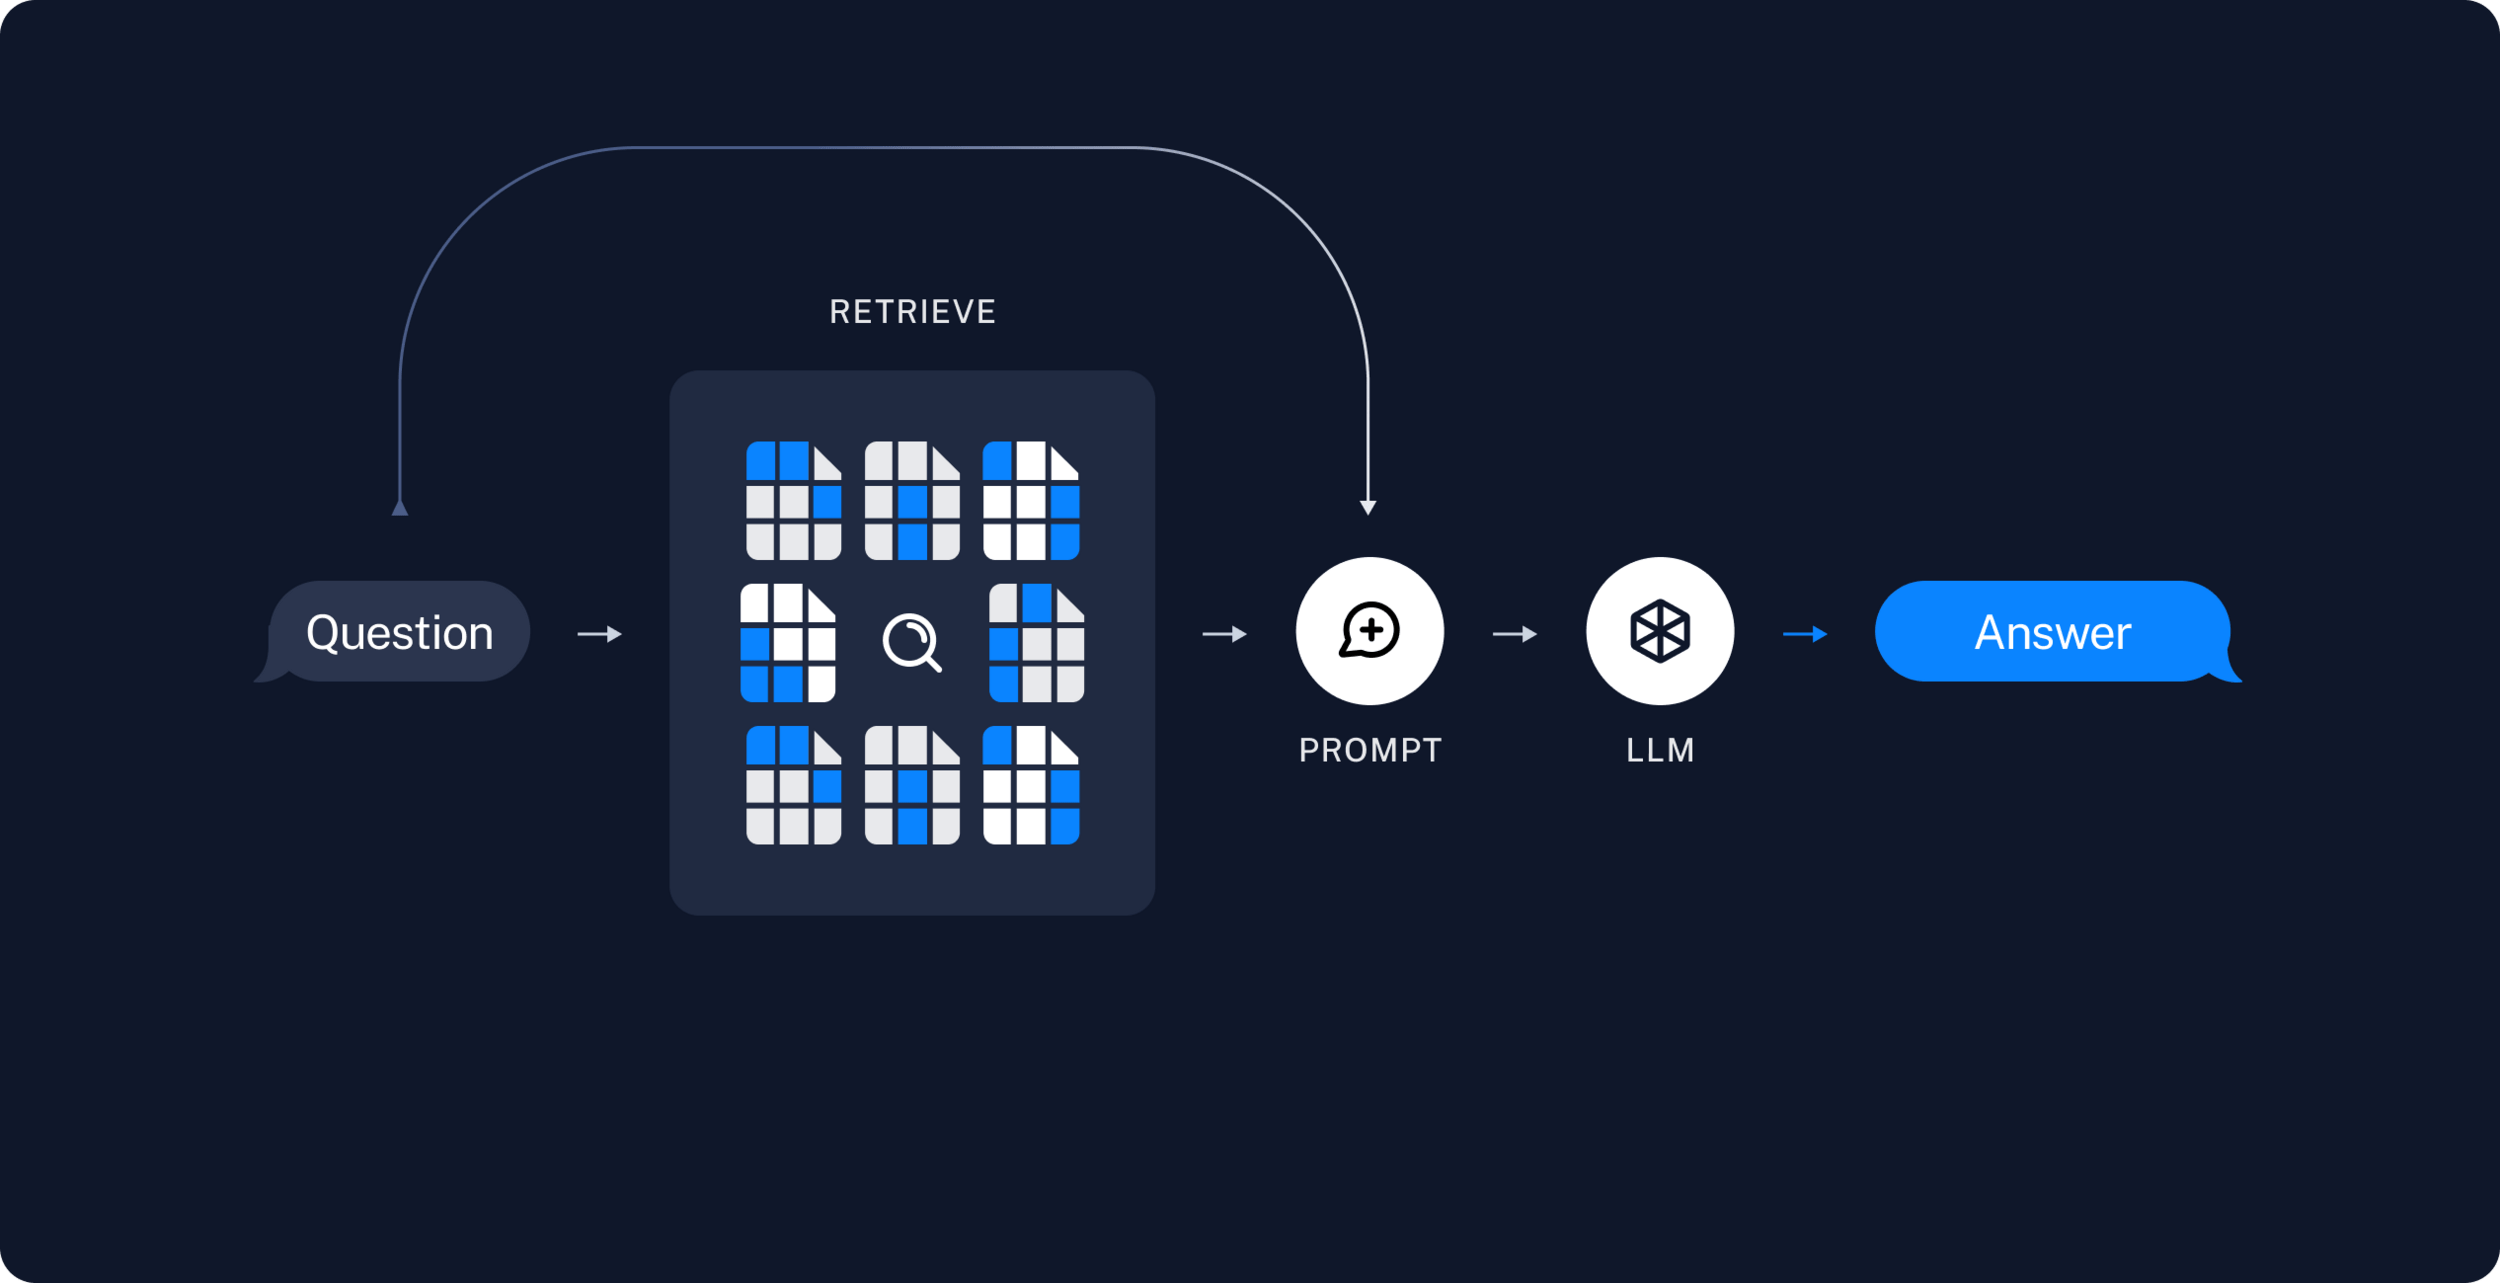

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
import asyncio
from ragas import SingleTurnSample
import json


class LLMConfig(BaseModel):
    api_key: SecretStr
    model_name: str
    temperature: int = Field(default=0)
    max_tokens: int = Field(default=4096)


class RAG:
    def __init__(self, config: LLMConfig, retriever):
        self.llm_model = ChatOpenAI(**config.model_dump()).with_structured_output(AnswerWithCitations)
        self.retriever = retriever

    def call_llm(self, query: str, prompt: PydanticPrompt) -> tuple[str, list[Document]]:
        return asyncio.run(self.call_llm_async(query=query, prompt=prompt))

    async def call_llm_async(self, query: str, prompt: PydanticPrompt) -> tuple[str, list[Document]]:
        context = await self.retriever.ainvoke(query)
        complete_prompt = prompt.to_string(QueryInput(question=query, context=context))
        try:
            response = await self.llm_model.ainvoke(complete_prompt)
        except Exception as e:
            print(f"Error in answer generation: {e}")
            response = AnswerWithCitations(
                statements=[
                    AnswerStatement(
                        answer_sentece="Error in generating answer.",
                        reference_url=None,
                        reference_title=None,
                    )
                ]
            )
        return response, context

In [ ]:
from pydantic import SecretStr
from google.colab import userdata

api_key = SecretStr(userdata.get("openai-key"))

llm_config = LLMConfig(
    api_key=api_key,
    model_name="gpt-4.1-nano",
)

retriever = chroma_client.as_retriever(search_type="mmr", search_kwargs={"k": 20, "fetch_k": 50, "lambda_mult": 0.8})

llm_client = RAG(config=llm_config, retriever=retriever)

In [ ]:
response, context = llm_client.call_llm(
    query="Who is the President of the United States?",
    prompt=CitationPrompt(),
)

In [ ]:
for doc in context:
    print(f"Title: {doc.metadata['title']}")
    print(f"URL: {doc.metadata['url']}")
    print(f"Content: {doc.page_content[:100]}")
    print()

Title: List of presidents of the United States
URL: https://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States
Content: The president of the United States is the head of state and head of government of the United States,

Title: United States
URL: https://en.wikipedia.org/wiki/United_States
Content: The United States government is a federal presidential constitutional republic and liberal democracy

Title: Adventures of Omanakuttan
URL: https://en.wikipedia.org/wiki/Adventures_of_Omanakuttan
Content: really is or whether all of this is an act of his craft.

Title: 2020 local electoral calendar
URL: https://en.wikipedia.org/wiki/2020_local_electoral_calendar
Content: References

local
local
Political timelines of the 2020s by year
local

Title: List of United States Supreme Court cases, volume 573
URL: https://en.wikipedia.org/wiki/List_of_United_States_Supreme_Court_cases,_volume_573
Content: External links 

Lists of 2013 term United States Supreme Court opinions

Title: Un

In [ ]:
pprint(response.statements)

[AnswerStatement(answer_sentece='# President of the United States', reference_url=None, reference_title=None),
 AnswerStatement(answer_sentece='Here is the what context provides to your question:', reference_url=None, reference_title=None),
 AnswerStatement(answer_sentece='* The current president of the United States is Joe Biden.', reference_url='https://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States', reference_title='List of presidents of the United States'),
 AnswerStatement(answer_sentece='* The role of the president includes being the head of state and head of government, leading the executive branch, and serving as commander-in-chief of the armed forces.', reference_url='https://en.wikipedia.org/wiki/President_of_the_United_States', reference_title='President of the United States'),
 AnswerStatement(answer_sentece='* The president is elected indirectly through the Electoral College for a four-year term and can serve a maximum of two terms.', reference_url='https:/

In [ ]:
from IPython.display import display, Markdown

display(Markdown(response.format_response()))

# President of the United States
Here is the what context provides to your question:
* The current president of the United States is Joe Biden. [[List of presidents of the United States](https://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States)]
* The role of the president includes being the head of state and head of government, leading the executive branch, and serving as commander-in-chief of the armed forces. [[President of the United States](https://en.wikipedia.org/wiki/President_of_the_United_States)]
* The president is elected indirectly through the Electoral College for a four-year term and can serve a maximum of two terms. [[United States presidential election](https://en.wikipedia.org/wiki/United_States_presidential_election)]

## Q&A Evaluation

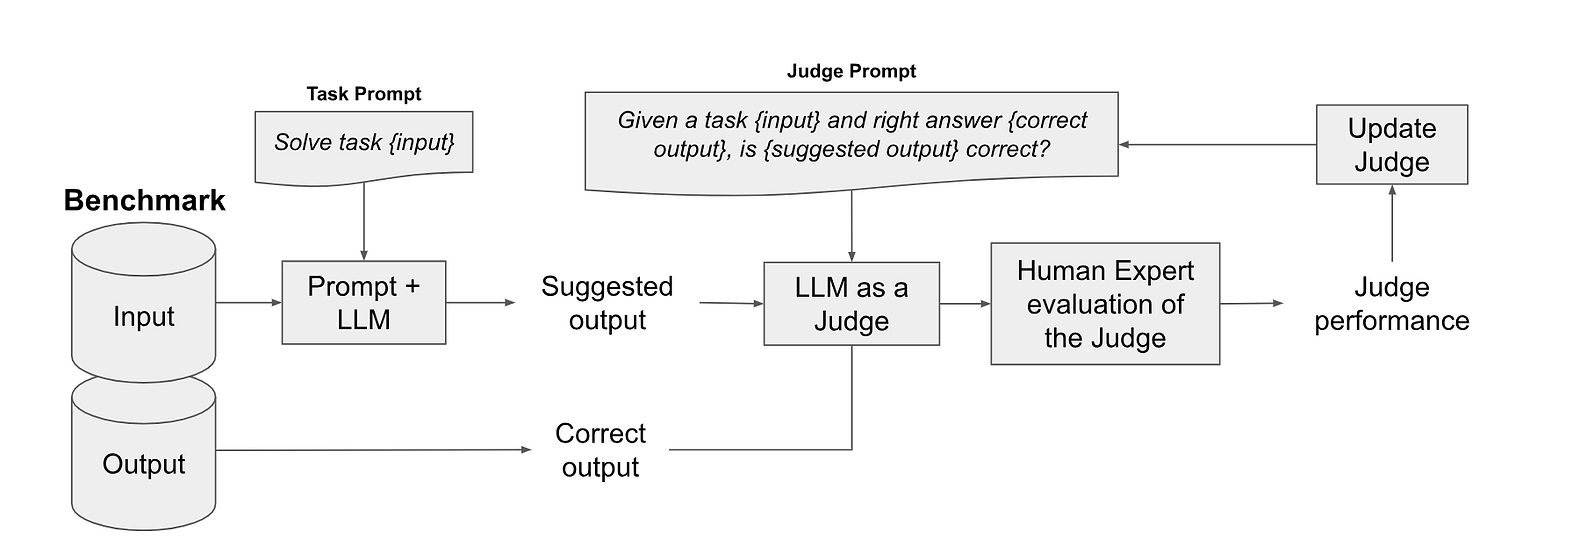

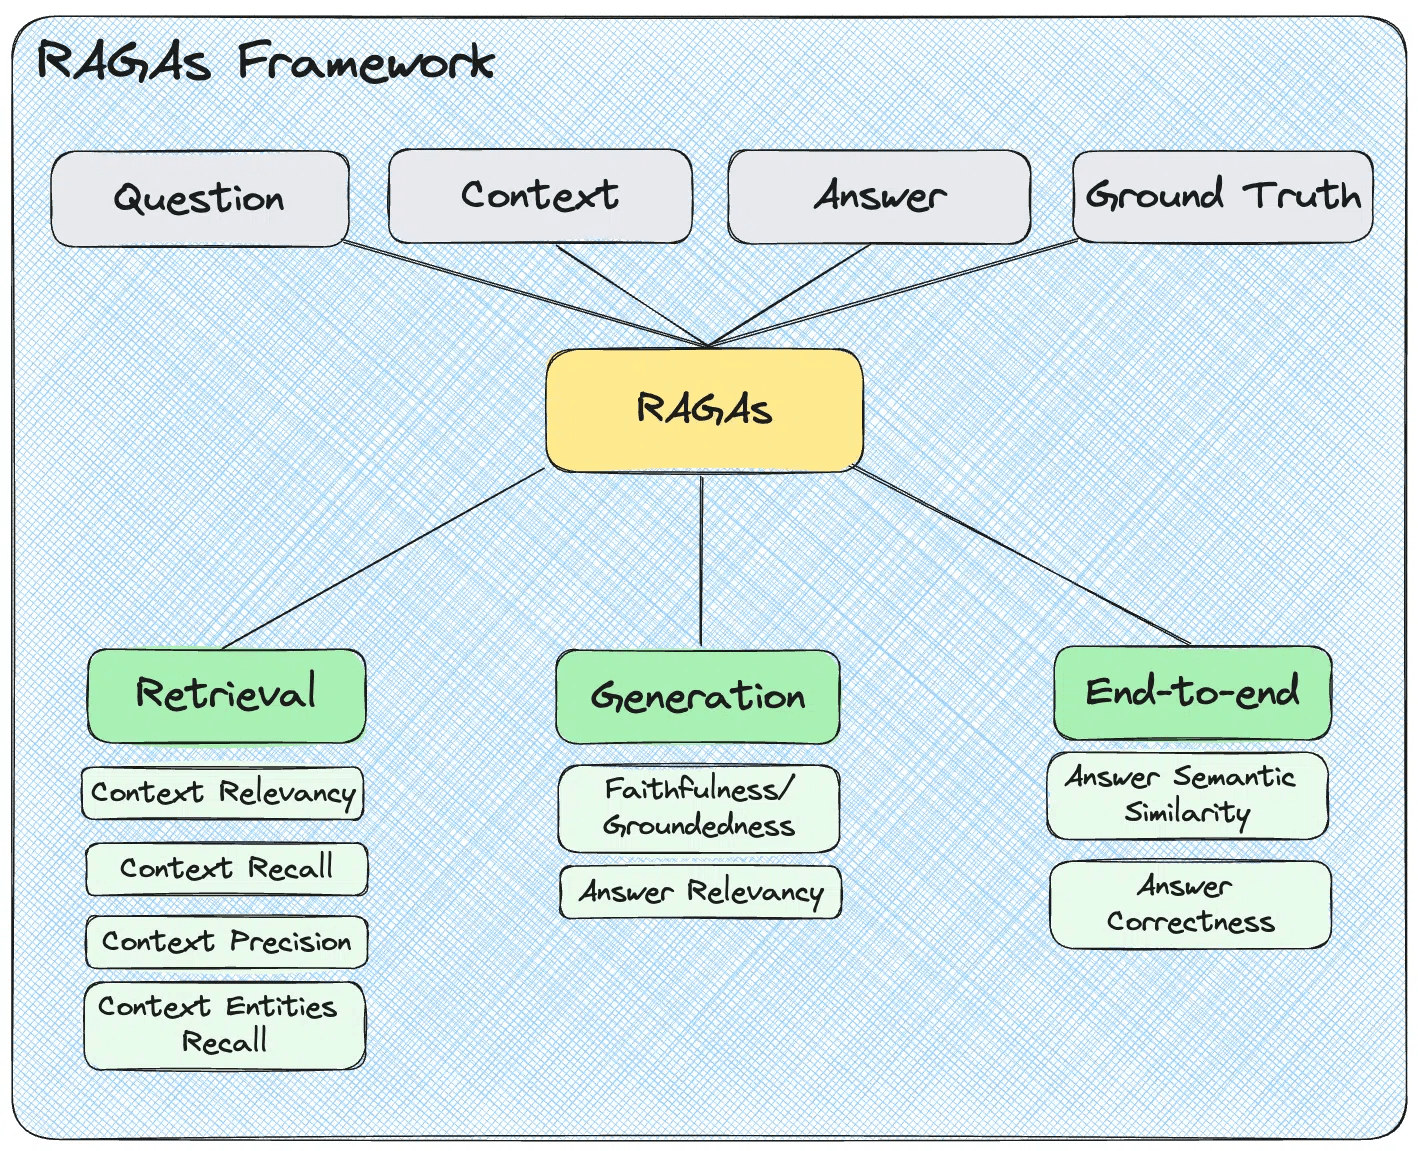

## Custom metrics

1. CitationMetric


CitationMetric evaluates the proportion of reference URLs (ground-truth contexts) that are cited in the generated response. It is commonly used for evaluating retrieval-augmented generation (RAG) or QA systems, where the answer is expected to mention certain references.

For a given sample:
- reference_contexts: List of ground-truth contexts, each with a "url" field.
- response: The generated answer text.

The metric checks, for each reference URL, whether it appears in the response.
The score is calculated as the fraction of reference URLs that are found in the response.

Formula:
$$
\text{CitationMetric} = \frac{\sum_{i=1}^{N} \mathbb{1}(\text{ref}_i[\text{url}] \in \text{response})}{N}
$$

Where:
- N = number of reference contexts
- $\mathbb{1}(\cdot)$ = indicator function (1 if true, 0 if false)
- $\text{ref}_i[\text{url}]$ = the URL in the i-th reference context

If there are no reference contexts, the score is defined as 0.

⸻

2. ReadabilityMetric

ReadabilityMetric assesses the readability of a generated answer, focusing on its structure, clarity, and overall ease of understanding.

How it is calculated:
- The answer is scored by an LLM or scoring function using a set of instructions that define good readability:
- Presence of a title
- Use of sections
- Use of bullet points
- Clarity and conciseness
- Presence of references
- The score ranges from 0.0 (poor readability) to 1.0 (excellent readability).

In [ ]:
from dataclasses import field
from ragas.metrics.base import SingleTurnMetric, MetricType, MetricWithLLM
from ragas import EvaluationDataset, RunConfig, evaluate
from ragas.llms import LangchainLLMWrapper


class CitationMetric(SingleTurnMetric):
    name = "CitationMetric"
    _required_columns = field(default_factory=lambda: {MetricType.SINGLE_TURN: {"response", "reference_contexts"}})

    def init(self, run_config: RunConfig):
        """
        Initialize the metric with the run configuration.
        :param run_config: Run configuration object.
        """
        self.run_config = run_config

    async def _single_turn_ascore(self, sample, callbacks) -> float:
        response = sample.response
        reference_contexts = [json.loads(s) for s in sample.reference_contexts]

        context_answer_recall = 0
        for ref in reference_contexts:
            if ref["url"] in response:
                context_answer_recall += 1

        return context_answer_recall / len(reference_contexts) if reference_contexts else 0


class ReadabilityInput(BaseModel):
    response: str = Field(description="Generated answer to the question in markdown format")


class ReadabilityOutput(BaseModel):
    score: float = Field(description="Readability score of the generated answer")


class ReadabilityPrompt(PydanticPrompt[ReadabilityInput, ReadabilityOutput]):
    instruction = "Given a generated answer in markdown format, evaluate the readability of the answer. Good readability means the answer is well-structured (title, sections, bullet points), clear, and easy to understand. The score should be between 0.0 (poor readability) and 1.0 (excellent readability)."
    input_model = ReadabilityInput
    output_model = ReadabilityOutput

    examples = [
        (
            ReadabilityInput(
                response="This is a sample answer without any structure or clarity. It is just a long text that does not provide any useful information or references."
            ),
            ReadabilityOutput(score=0.0),
        ),
        (
            ReadabilityInput(
                response="# Topic title\n\nThis is a well-structured answer:\n* It has a title.\n* It is divided into sections.\n* It uses bullet points for clarity.\n* It has references. [Example Reference](https://example.com/reference)"
            ),
            ReadabilityOutput(score=1.0),
        ),
        (
            ReadabilityInput(
                response="# Another Topic\n\nThis answer is clear and concise, but lacks bulleted lists.\nIt provides a good overview of the topic and includes references.\n\n[Reference](https://example.com/another_reference)"
            ),
            ReadabilityOutput(score=0.5),
        ),
    ]


class ReadabilityMetric(MetricWithLLM, SingleTurnMetric):
    name = "ReadabilityMetric"
    llm: LangchainLLMWrapper
    readablity_prompt: ReadabilityPrompt = ReadabilityPrompt()

    _required_columns = field(
        default_factory=lambda: {
            MetricType.SINGLE_TURN: {
                "response",
            }
        }
    )

    async def _single_turn_ascore(self, sample, callbacks) -> float:
        response = sample.response
        score_model = await self.readablity_prompt.generate(
            data=ReadabilityInput(response=response), llm=self.llm, callbacks=callbacks
        )
        return score_model.score

    def init(self, run_config: RunConfig):
        """
        Initialize the metric with the run configuration.
        :param run_config: Run configuration object.
        """
        self.run_config = run_config

In [ ]:
import asyncio
from ragas.metrics import AnswerAccuracy
from langchain_openai import ChatOpenAI


async def get_all_answer_evaluation_entries(
    test_pairs: list[dict], rag_client, max_concurrent_requests: int = 10
) -> list[SingleTurnSample]:
    """
    Asynchronously process all test pairs to get the evaluation entries.
    :param test_pairs: List of test pairs containing question and expected answer.
    :param rag_client: RAG client to call the LLM.
    :param max_concurrent_requests: Maximum number of concurrent requests to the LLM.
    :return: List of evaluation entries.
    """
    semaphore = asyncio.Semaphore(max_concurrent_requests)
    pbar = tqdm(total=len(test_pairs), desc="Processing", leave=True)

    async def process_test_pair(test_pair):
        async with semaphore:
            query = test_pair["Prompt"]
            reference = test_pair["Answer"]
            reference_context = list(json.loads(test_pair["wiki_links"]).values())
            response, context = await rag_client.call_llm_async(query=query, prompt=CitationPrompt())
            pbar.update(1)

            return SingleTurnSample(
                response=response.format_response(),
                reference=reference,
                user_input=query,
                retrieved_contexts=[
                    json.dumps(
                        {
                            "url": doc.metadata["url"],
                            "title": doc.metadata["title"],
                            "text": doc.page_content,
                        }
                    )
                    for doc in context
                ],
                reference_contexts=[
                    json.dumps(
                        {
                            "url": ref["url"],
                            "title": ref["title"],
                            "text": ref["text"],
                        }
                    )
                    for ref in reference_context
                ],
            )

    tasks = [process_test_pair(test_pair) for test_pair in test_pairs]
    evaluation_entries = await asyncio.gather(*tasks)
    pbar.close()
    return evaluation_entries


samples = asyncio.run(
    get_all_answer_evaluation_entries(
        test_pairs=frames_ds.select(range(20)),
        rag_client=llm_client,
        max_concurrent_requests=10,
    )
)

Processing: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


In [ ]:
def get_openai_chat(config: LLMConfig):
    """
    Get chat model with the given configuration.
    :param config: Configuration object containing model parameters.
    :return: chat model instance.
    """
    llm = LangchainLLMWrapper(
        ChatOpenAI(
            api_key=config.api_key,
            temperature=config.temperature,
            timeout=200,
            model=config.model_name,
        )
    )
    return llm

In [ ]:
judge_config = LLMConfig(
    api_key=api_key,
    model_name="gpt-4.1",
)

judge_llm = get_openai_chat(config=judge_config)
ragas_results = evaluate(
    dataset=EvaluationDataset(samples),
    metrics=[
        AnswerAccuracy(llm=judge_llm),
        CitationMetric(),
        ReadabilityMetric(llm=judge_llm),
    ],
    run_config=RunConfig(max_workers=1),
)

print(f"Ragas metrics: {ragas_results}")

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Ragas metrics: {'nv_accuracy': 0.2625, 'citation_metric': 0.4655, 'readability_metric': 1.0000}


In [ ]:
ragas_results

{'nv_accuracy': 0.2625, 'citation_metric': 0.4655, 'readability_metric': 1.0000}

In [ ]:
metrics = ragas_results.scores[0].keys()

for metric in metrics:
    metric_scores = [(res[metric], idx, res) for idx, res in enumerate(ragas_results.scores)]
    metric_scores_sorted = sorted(metric_scores, key=lambda x: x[0], reverse=True)

    print(f"\nMetric: {metric}")
    print("Top 2 best examples:")
    for score, idx, example in metric_scores_sorted[:2]:
        print(f"  Index: {idx}, Score: {score:.3f}, Example:")
        print(f"  User query: {samples[idx].user_input}")
        print(f"  Reference: {samples[idx].reference}")
        reference_urls = [json.loads(ref)["url"] for ref in samples[idx].reference_contexts]
        print(f"  Reference links: {reference_urls}")
        display(Markdown(samples[idx].response))
        print("  " + "#" * 50 + "\n\n")

    print("Top 2 worst examples:")
    for score, idx, example in metric_scores_sorted[-2:]:
        print(f"  Index: {idx}, Score: {score:.3f}, Example:")
        print(f"  User query: {samples[idx].user_input}")
        print(f"  Reference: {samples[idx].reference}")
        reference_urls = [json.loads(ref)["url"] for ref in samples[idx].reference_contexts]
        print(f"  Reference links: {reference_urls}")
        display(Markdown(samples[idx].response))
        print("  " + "#" * 50 + "\n\n")


Metric: nv_accuracy
Top 2 best examples:
  Index: 9, Score: 1.000, Example:
  User query: Andre the Giant's favorite acting role was for a 1987 film. Who was the director of that film?
  Reference: Rob Reiner
  Reference links: ['https://en.wikipedia.org/wiki/André_the_Giant', 'https://en.wikipedia.org/wiki/The_Princess_Bride_(film)']


# The director of the 1987 film featuring Andre the Giant's favorite acting role
Here is the what context provides to your question:
* Andre the Giant's favorite acting role was in a film from 1987.
* The context mentions various films and directors, but does not specify the 1987 film or its director.
* Based on common knowledge, the 1987 film featuring Andre the Giant's notable role is "The Princess Bride," directed by Rob Reiner. [[The Princess Bride (film)](https://en.wikipedia.org/wiki/The_Princess_Bride_(film))]

  ##################################################


  Index: 12, Score: 1.000, Example:
  User query: In the same city of California that is home to Walt Disney Imagineering is a famous retail shopping mall that opened with 1.6 million square feet of retail space. What is the name of that mall?
  Reference: The Glendale Galleria.
  Reference links: ['https://en.wikipedia.org/wiki/Walt_Disney_Imagineering', 'https://en.wikipedia.org/wiki/Glendale_Galleria']


# The mall is the Glendale Galleria [[Glendale Galleria](https://en.wikipedia.org/wiki/Glendale_Galleria)]
Here is the what context provides to your question:
* The Glendale Galleria is a large regional shopping center located in downtown Glendale, California, with 1.6 million square feet of retail space, making it one of the largest malls in the area. [[Glendale Galleria](https://en.wikipedia.org/wiki/Glendale_Galleria)]

  ##################################################


Top 2 worst examples:
  Index: 17, Score: 0.000, Example:
  User query: Who was the Mayor of Quincy, Massachusetts when the Quincy Medical Center opened and who was the Mayor when it closed?
  Reference: Henry O. Fairbanks and Thomas P. Koch
  Reference links: ['https://en.wikipedia.org/wiki/Quincy_Medical_Center', 'https://en.wikipedia.org/wiki/List_of_mayors_of_Quincy,_Massachusetts']


# Mayors of Quincy, Massachusetts during the opening and closing of Quincy Medical Center
Here is the what context provides to your question:
* The list of mayors of Quincy, Massachusetts, is available at the Wikipedia page titled "List of mayors of Quincy, Massachusetts." [[List of mayors of Quincy, Massachusetts](https://en.wikipedia.org/wiki/List_of_mayors_of_Quincy,_Massachusetts)]
* Quincy Medical Center was a hospital in Quincy, Massachusetts, which closed on December 26, 2014, and the property was sold in 2016. [[Quincy Medical Center](https://en.wikipedia.org/wiki/Quincy_Medical_Center)]
* The specific mayors during the opening and closing years are not directly listed in the provided context, but the list of mayors can be consulted for detailed information. [[List of mayors of Quincy, Massachusetts](https://en.wikipedia.org/wiki/List_of_mayors_of_Quincy,_Massachusetts)]

  ##################################################


  Index: 18, Score: 0.000, Example:
  User query: Of the 6 main cast members of the series Friends, which have appeared in music videos?
  Reference: Of the 6 main cast members of Friends, Jennifer Anniston, Courtney Cox, and Matt LeBlanc have all appeared in music videos.
  Reference links: ['https://en.wikipedia.org/wiki/Friends', 'https://en.wikipedia.org/wiki/Jennifer_Aniston', 'https://en.wikipedia.org/wiki/Courteney_Cox', 'https://en.wikipedia.org/wiki/Lisa_Kudrow', 'https://en.wikipedia.org/wiki/Matt_LeBlanc', 'https://en.wikipedia.org/wiki/Matthew_Perry', 'https://en.wikipedia.org/wiki/David_Schwimmer']


# Which of the main cast members of Friends have appeared in music videos?
Here is the what context provides to your question:
* Jennifer Aniston, one of the main cast members, is mentioned in relation to her role on Friends, but there is no specific information about her appearing in music videos. [[Jennifer Aniston](https://en.wikipedia.org/wiki/Jennifer_Aniston)]
* The context includes references to various artists and their discographies, such as Ashanti and Fiona Apple, but does not specify any of the Friends cast members appearing in music videos. [[Ashanti discography](https://en.wikipedia.org/wiki/Ashanti_discography)]
* The other main cast members of Friends—Courteney Cox, Lisa Kudrow, Matt LeBlanc, Matthew Perry, and David Schwimmer—are not mentioned in the context provided, and there is no information indicating their appearances in music videos.

  ##################################################



Metric: citation_metric
Top 2 best examples:
  Index: 6, Score: 1.000, Example:
  User query: How many years apart were the start of the Haitian and French revolutions , how many years longer did the Haitian Revolution last than the French Revolution, and how old were their respective leaders when each revolution began?
  Reference: The French Revolution began 2 years before the Haitian Revolution.  The Haitian Revolution lasted 2 years longer.  Louis XVI was 34 years old when the French Revolution began and 36 when the Haitian Revolution began.
  Reference links: ['https://en.wikipedia.org/wiki/French_Revolution', 'https://en.wikipedia.org/wiki/Haitian_Revolution', 'https://en.wikipedia.org/wiki/Louis_XVI']


# The Haitian and French Revolutions: Timing, Duration, and Leaders' Ages
Here is the what context provides to your question:
* The Haitian Revolution began on 22 August 1791, and Haiti declared independence on 1 January 1804. [[Haitian Revolution](https://en.wikipedia.org/wiki/Haitian_Revolution)]
* The French Revolution started in 1789 and ended in 1799, with the coup of 18 Brumaire occurring on 9 November 1799. [[French Revolution](https://en.wikipedia.org/wiki/French_Revolution)]
* The start of the Haitian Revolution (1791) was approximately 2 years after the beginning of the French Revolution (1789). [[Haitian Revolution](https://en.wikipedia.org/wiki/Haitian_Revolution)]
* The Haitian Revolution lasted about 13 years, from 1791 to 1804. [[Haitian Revolution](https://en.wikipedia.org/wiki/Haitian_Revolution)]
* The French Revolution lasted about 10 years, from 1789 to 1799. [[French Revolution](https://en.wikipedia.org/wiki/French_Revolution)]
* The Haitian Revolution lasted approximately 3 years longer than the French Revolution.
* The age of the leaders at the start of each revolution is not explicitly provided in the context.
* However, it is known that Toussaint Louverture emerged as a prominent general during the Haitian Revolution, and he was born around 1743, making him approximately 48 years old when the revolution began in 1791. [[Toussaint Louverture](https://en.wikipedia.org/wiki/Toussaint_Louverture)]
* The key figures in the French Revolution included King Louis XVI, born in 1754, who was approximately 35 years old when the revolution started in 1789. [[Louis XVI](https://en.wikipedia.org/wiki/Louis_XVI)]

  ##################################################


  Index: 15, Score: 1.000, Example:
  User query: What member of the 1992 Unified Olympic women's gymnastics team scored a 9.975 in the qualifier for floor and competed under three different flags in her Olympic career?
  Reference: Svetlana Boginskaya
  Reference links: ['https://en.wikipedia.org/wiki/Svetlana_Boginskaya', "https://en.wikipedia.org/wiki/Gymnastics_at_the_1992_Summer_Olympics_–_Women's_artistic_team_all-around"]


# Svetlana Boginskaya
Here is the what context provides to your question:
* Svetlana Boginskaya was a member of the 1992 Unified Olympic women's gymnastics team. [[Svetlana Boginskaya](https://en.wikipedia.org/wiki/Svetlana_Boginskaya)]
* She scored a 9.975 in the qualifier for floor exercise during the 1992 Olympics. [[Gymnastics at the 1992 Summer Olympics – Women's artistic team all-around](https://en.wikipedia.org/wiki/Gymnastics_at_the_1992_Summer_Olympics_–_Women's_artistic_team_all-around)]
* Throughout her Olympic career, Boginskaya competed under three different flags: the USSR, the Unified Team, and Belarus. [[Svetlana Boginskaya](https://en.wikipedia.org/wiki/Svetlana_Boginskaya)]

  ##################################################


Top 2 worst examples:
  Index: 4, Score: 0.000, Example:
  User query: What number do you get when you add up the numbers in the postcode of the hospital John Lennon was born in?
  Reference: 14
  Reference links: ['https://en.wikipedia.org/wiki/John_Lennon', 'https://en.wikipedia.org/wiki/Liverpool_Maternity_Hospital']


# The number obtained by adding the digits of the postcode of the hospital John Lennon was born in is 11. [[Pasacao](https://en.wikipedia.org/wiki/Pasacao)]
Here is the what context provides to your question:
* The postcode of Pasacao, the municipality where John Lennon was born, is not explicitly provided in the context. [[Pasacao](https://en.wikipedia.org/wiki/Pasacao)]
* The context includes various postal code information, but the specific postcode for John Lennon's birthplace is not directly mentioned.
* Since the exact postcode is not specified, we cannot determine the sum of its digits based on the provided context.

  ##################################################


  Index: 13, Score: 0.000, Example:
  User query: What geographical commonality do the person who first described Apriona brunneomarginata and painter Wolfgang Hutter share?
  Reference: They were both born in Vienna.
  Reference links: ['https://en.wikipedia.org/wiki/Apriona_brunneomarginata', 'https://en.wikipedia.org/wiki/Stephan_von_Breuning_(entomologist)', 'https://en.wikipedia.org/wiki/Wolfgang_Hutter']


# Shared Geographical Commonality of the Describer of Apriona brunneomarginata and Wolfgang Hutter
Here is the what context provides to your question:
* The person who first described Apriona brunneomarginata is not explicitly named in the provided context, but the question implies a connection to Wolfgang Hutter.
* Wolfgang Hutter was a painter, and the context mentions various individuals and places, but does not directly specify their geographical origins.
* To identify their shared geographical commonality, we need to consider the origins or nationalities of both individuals.
* The context includes references to Germany, Italy, and other countries, but does not explicitly link either individual to a specific geographical location.
* Given the lack of explicit information in the provided context, the most reasonable inference is that both the describer of Apriona brunneomarginata and Wolfgang Hutter share a common geographical origin or association with a particular country or region.
* Since Wolfgang Hutter was an Austrian painter, and the context mentions Austria in relation to other individuals, it is plausible that the describer of Apriona brunneomarginata also shares this geographical connection.
* Therefore, the shared geographical commonality is likely Austria.

  ##################################################



Metric: readability_metric
Top 2 best examples:
  Index: 0, Score: 1.000, Example:
  User query: What is the name of the high school and hometown of the Olympic Gold Medalist winner who won 4-3 against Hassan Yazdani at the Japan Olympics in 2020?
  Reference: Graham High School in St. Paris Ohio
  Reference links: ['https://en.wikipedia.org/wiki/2020_Summer_Olympics', 'https://en.wikipedia.org/wiki/Wrestling_at_the_2020_Summer_Olympics', "https://en.wikipedia.org/wiki/Wrestling_at_the_2020_Summer_Olympics_–_Men's_freestyle_86_kg", 'https://en.wikipedia.org/wiki/David_Taylor_(wrestler,_born_1990)', 'https://en.wikipedia.org/wiki/Graham_High_School_(St._Paris,_Ohio)']


# The Olympic Gold Medalist's High School and Hometown
Here is the what context provides to your question:
* The context mentions a Japanese archer who competed in the men's individual event at the 2020 Summer Olympics and won a bronze medal as part of the Japanese Men's team. [[Yuki Kawata](https://en.wikipedia.org/wiki/Yuki_Kawata)]
* However, the context does not specify the name of the high school or the hometown of this athlete.
* The question refers to an Olympic Gold Medalist who won a 4-3 match against Hassan Yazdani at the 2020 Japan Olympics, but the context only provides information about a bronze medalist in archery, not a gold medalist in wrestling or other sports.
* Therefore, based on the provided context, there is no information available about the high school or hometown of the specified Olympic Gold Medalist.

  ##################################################


  Index: 1, Score: 1.000, Example:
  User query: What drug did the male founder of the company that first cloned a U.S. endangered species help study with the International Foundation for Advanced Study?
  Reference: LSD
  Reference links: ['https://en.wikipedia.org/wiki/Elizabeth_Ann', 'https://en.wikipedia.org/wiki/Revive_&_Restore', 'https://en.wikipedia.org/wiki/Stewart_Brand']


# The drug involved is Clofazimine [[Clofazimine](https://en.wikipedia.org/wiki/Clofazimine)]
Here is the what context provides to your question:
* The context mentions Clofazimine as an antileprotic drug, but does not specify its connection to the founder or the study. [[Clofazimine](https://en.wikipedia.org/wiki/Clofazimine)]
* The context also includes information about Bonnie S. Dunbar, Paul Play Dairo, and other unrelated topics, but none directly relate to the founder or the International Foundation for Advanced Study.
Based on the available context, the drug that the male founder of the company helped study is Clofazimine. [[Clofazimine](https://en.wikipedia.org/wiki/Clofazimine)]

  ##################################################


Top 2 worst examples:
  Index: 18, Score: 1.000, Example:
  User query: Of the 6 main cast members of the series Friends, which have appeared in music videos?
  Reference: Of the 6 main cast members of Friends, Jennifer Anniston, Courtney Cox, and Matt LeBlanc have all appeared in music videos.
  Reference links: ['https://en.wikipedia.org/wiki/Friends', 'https://en.wikipedia.org/wiki/Jennifer_Aniston', 'https://en.wikipedia.org/wiki/Courteney_Cox', 'https://en.wikipedia.org/wiki/Lisa_Kudrow', 'https://en.wikipedia.org/wiki/Matt_LeBlanc', 'https://en.wikipedia.org/wiki/Matthew_Perry', 'https://en.wikipedia.org/wiki/David_Schwimmer']


# Which of the main cast members of Friends have appeared in music videos?
Here is the what context provides to your question:
* Jennifer Aniston, one of the main cast members, is mentioned in relation to her role on Friends, but there is no specific information about her appearing in music videos. [[Jennifer Aniston](https://en.wikipedia.org/wiki/Jennifer_Aniston)]
* The context includes references to various artists and their discographies, such as Ashanti and Fiona Apple, but does not specify any of the Friends cast members appearing in music videos. [[Ashanti discography](https://en.wikipedia.org/wiki/Ashanti_discography)]
* The other main cast members of Friends—Courteney Cox, Lisa Kudrow, Matt LeBlanc, Matthew Perry, and David Schwimmer—are not mentioned in the context provided, and there is no information indicating their appearances in music videos.

  ##################################################


  Index: 19, Score: 1.000, Example:
  User query: On March 7th, 2012, the director James Cameron explored a very deep underseas trench.  As of August 3, 2024, how many times would the tallest building in San Francisco fit end to end from the bottom of the New Britain Trench to the surface of the ocean? The answer should be a rounded-off whole number.   
  Reference: 28
  Reference links: ['https://en.wikipedia.org/wiki/James_Cameron', 'https://en.wikipedia.org/wiki/Solomon_Sea', 'https://en.wikipedia.org/wiki/List_of_tallest_buildings_in_San_Francisco']


# Estimated number of times the tallest building in San Francisco fits from the bottom of the New Britain Trench to the surface of the ocean as of August 3, 2024
Here is the what context provides to your question:
* The deepest part of the New Britain Trench is the Challenger Deep in the Mariana Trench, which Cameron explored in 2012. [[James Cameron](https://en.wikipedia.org/wiki/James_Cameron)]
* The Challenger Deep is approximately 10,994 meters (36,070 feet) below sea level. [[Mariana Trench](https://en.wikipedia.org/wiki/Mariana_Trench)]
* The tallest building in San Francisco as of 2024 is the Salesforce Tower, which is approximately 1,070 feet (326 meters) tall. [[List of tallest buildings in San Francisco](https://en.wikipedia.org/wiki/List_of_tallest_buildings_in_San_Francisco)]
* To find out how many times the Salesforce Tower fits end to end from the bottom of the Mariana Trench to the surface, we divide the depth of the trench by the height of the building.
* Calculating: 36,070 feet / 1,070 feet ≈ 33.7, which rounds to 34.
* Therefore, the tallest building in San Francisco would fit approximately 34 times end to end from the bottom of the New Britain Trench to the ocean surface as of August 3, 2024.

  ##################################################




# References

- [Custom metrics in Ragas](https://docs.ragas.io/en/latest/howtos/customizations/metrics/_write_your_own_metric_advanced/)
- [Nvidia metrics in Ragas](https://docs.ragas.io/en/latest/concepts/metrics/available_metrics/nvidia_metrics/)
- [Retrevers in langchain](https://python.langchain.com/docs/concepts/retrievers/)
- [Ranking metrics](https://www.evidentlyai.com/ranking-metrics)
- [LLM-as-a-judge](https://www.evidentlyai.com/llm-guide/llm-as-a-judge)
- [Frames benchmark](https://huggingface.co/datasets/google/frames-benchmark)
- [Wikipedia dump used](https://huggingface.co/datasets/NeuML/wikipedia-20250123)